In [259]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score

In [260]:
# ! pip install umap-learn

#### Display options

In [261]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 25)

##### Load the embeddings representations for HCP dataset which is partially labeled (X_train will be the training set, from HCP, y_train the target)

In [262]:
OFC_labels= pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/hcp/hcp_OFC_labels_from_0.csv")#, index_col=0)
print(OFC_labels.head())
OFC_labels.shape

   Subject  Right_OFC Right_Subtype_OFC  Left_OFC Left_Subtype_OFC
0   100307          0                 B         1                F
1   100408          0                 N         1                E
2   100610          0                 A         0                A
3   101006          0                 B         0                A
4   101410          1                 A         1                I


(577, 5)

In [263]:
OFC_labels = OFC_labels[['Subject','Left_OFC','Left_Subtype_OFC']]

In [264]:
'''
def encoder(df, col):
    code = {'A':1,
            'B':0}
    df[col] = df[col].map(code)
    return df

encoder(OFC_labels,'Left_Subtype_OFC') 
'''

"\ndef encoder(df, col):\n    code = {'A':1,\n            'B':0}\n    df[col] = df[col].map(code)\n    return df\n\nencoder(OFC_labels,'Left_Subtype_OFC') \n"

In [265]:
OFC_labels['Left_OFC'].unique()

array([1, 0, 2, 3])

In [266]:
embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Output/20-56-02_3/HCP_random_epoch70_embeddings/full_embeddings.csv")#, index_col=0)
embeddings_HCP.head()

,ID,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
0,100206,-37.116917,-6.121184,-25.928839,-0.514293,-1.127414,2.116426,4.552599,-6.961069,-18.489483,-5.073837,5.725350,...,4.702526,8.392426,-7.573673,-6.077667,0.193669,11.052737,1.049304,11.587242,8.570839,14.021003,8.010570,-7.961619
1,100307,-41.740660,-20.830635,-4.394322,4.695328,-0.132281,9.025384,-22.300158,-8.898496,5.184516,23.043724,23.394463,...,-0.197523,-0.831337,11.243299,3.041513,-9.376342,3.796192,10.819851,3.911508,-35.655354,-7.376559,-8.005059,-4.728900
2,100408,-24.743023,-24.405981,-8.721355,0.960315,-0.582510,16.091053,-12.593547,-3.609672,22.432001,-15.703435,-17.314741,...,-4.973150,10.001007,-5.336519,-9.919937,-17.496368,-5.637656,27.274302,-6.697484,4.092987,6.854706,3.655995,-12.591545
3,100610,-43.925236,-0.432602,-7.898960,14.522940,6.974005,-4.757513,-3.930197,2.638632,-2.534404,6.359335,5.543898,...,-5.556941,-24.197195,25.578115,17.473066,4.532699,-19.535366,14.092745,17.121790,27.954803,-28.908329,-0.346371,15.307954
4,101006,-45.318027,-12.814513,6.508678,1.289449,-0.053654,-27.591760,-9.936734,-5.246563,-9.141480,30.246105,-14.398569,...,-9.715414,-20.083223,7.860282,6.417887,-40.846880,-21.585997,7.220089,24.983307,17.156185,-27.307580,1.664228,2.370009


In [267]:
embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Output/20-56-02_3/UKB_random_epoch70_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-25.850504,-21.999670,7.089681,2.264146,-17.281126,-0.404646,2.859115,-6.836255,-18.238863,3.145421,-12.351563,18.590230,...,-0.974415,0.892668,-3.146886,-0.149955,6.566947,-22.473553,6.554144,4.883575,29.443010,-18.397890,11.301130,-1.173351
sub-1000458,-39.752228,9.352198,-24.499321,3.113222,10.297467,4.385118,7.537263,5.938859,-26.613037,-0.325716,22.327143,15.051600,...,1.186649,0.212778,-6.275209,1.090302,-2.154455,2.020467,-2.953859,15.833322,13.132705,1.806404,15.055682,10.118515
sub-1000575,-43.504500,-30.933372,9.031720,-4.343265,5.278460,5.459973,-16.458965,-18.428880,-13.296448,-6.306728,29.042162,9.946109,...,8.263718,-4.676533,-3.045086,4.570945,-25.498163,38.142170,0.184133,-13.425387,5.010011,4.025597,13.959010,8.422810
sub-1000606,-49.737125,-11.154046,-30.825222,-10.888798,22.786974,0.624909,-14.620570,9.387497,33.835365,28.014297,59.921047,3.859730,...,-30.119352,-0.898748,-0.455343,-8.081720,-34.495083,22.399952,-10.751467,-1.600565,-15.131803,8.682613,17.231340,2.580372
sub-1000963,-31.846552,-11.682108,-14.411015,-6.827055,27.012436,-1.946492,-10.811785,3.841172,12.930974,15.259936,14.264213,27.766748,...,-19.288597,12.453719,-7.665420,-21.405096,-35.415810,0.007036,10.601191,3.470737,-7.982464,-13.441554,18.653915,0.879115


#### Scaler

In [268]:
ebdd_lbl_HCP = embeddings_HCP.set_index('ID').join(OFC_labels.set_index('Subject'), how='inner')
X_train = ebdd_lbl_HCP.drop(['Left_OFC','Left_Subtype_OFC'], axis=1)
y_train = ebdd_lbl_HCP['Left_OFC'].to_numpy()

The scaler is fited on the UKB database at first, it transforms it and then transforms the HCP dataset.

In [269]:
scaler = StandardScaler()
scaler.fit(embeddings_UKB)
X_train = scaler.transform(X_train)
scl_bdd_hcp = scaler.transform(embeddings_HCP.drop('ID', axis=1))
X_train.shape ,scl_bdd_hcp.shape

((577, 256), (1114, 256))

#### SVC model, training on Troiani's dataset

In [270]:
multi_class = 'ovr'

#from train_multiple_classifiers import train_classifiers,train_one_classifier
model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape=multi_class)

Let's first look at auc's value for the linear classification model with a cross validation of 5.

In [271]:
np.random.seed(51)
outputs = {}
val_pred_proba = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')
val_pred = cross_val_predict(model, X_train, y_train, cv=5, method='predict')
auc = roc_auc_score(y_train, val_pred_proba, multi_class=multi_class)
outputs['labels_pred'] = val_pred_proba
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y_train, val_pred)

print(f'auc_cv: {outputs["auc"]}')
print(f'balanced_accuracy_score_cv: {outputs["balanced_accuracy_score"]}')

auc_cv: 0.791073890145476
balanced_accuracy_score_cv: 0.49739606128409797


Auc's value below is not reliable, as we train on the whole model to test on the whole model.

In [272]:
model.fit(X_train,y_train)

roc_auc_score(y_train,model.predict_proba(X_train),multi_class=multi_class), balanced_accuracy_score(y_train, model.predict(X_train))

(0.8605800176445968, 0.6257453793791385)

With the multi_class: ovr


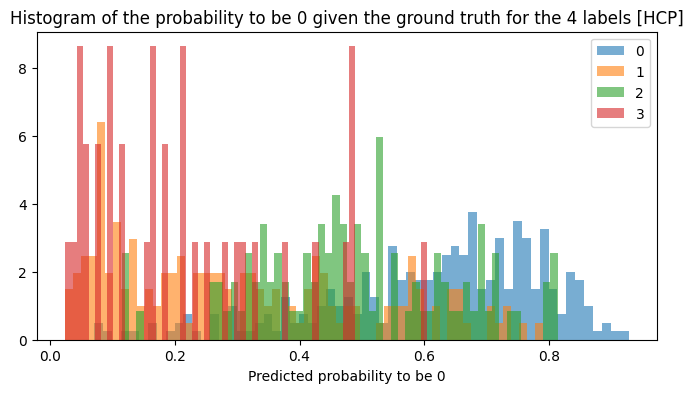

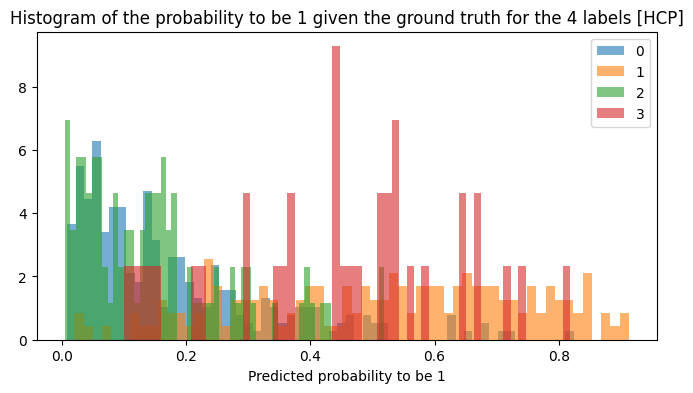

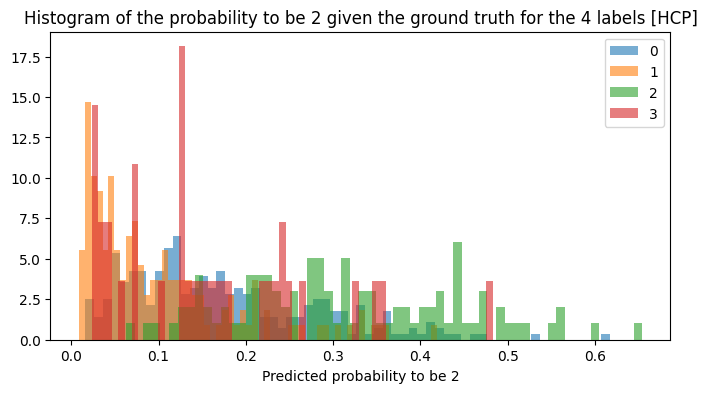

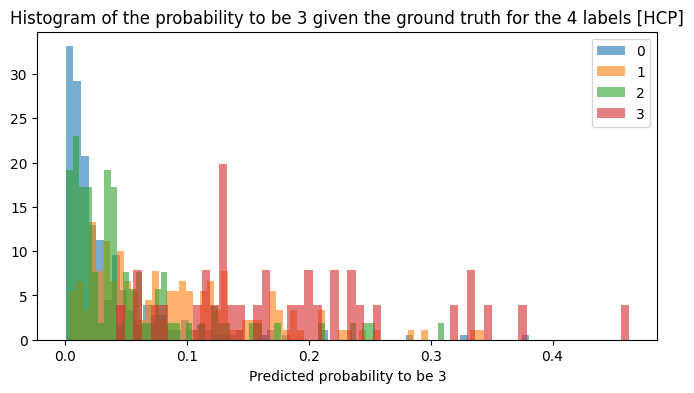

In [273]:
print(f'With the multi_class: {multi_class}')
for i in range(4):
    plt.figure(figsize=(8,4))
    plt.hist(model.predict_proba(X_train)[y_train==0,i], bins=60, alpha=0.6, label='0', density=True)
    plt.hist(model.predict_proba(X_train)[y_train==1,i], bins=60, alpha=0.6, label='1', density=True)
    plt.hist(model.predict_proba(X_train)[y_train==2,i], bins=60, alpha=0.6, label='2', density=True)
    plt.hist(model.predict_proba(X_train)[y_train==3,i], bins=60, alpha=0.6, label='3', density=True)
    plt.xlabel(f'Predicted probability to be {i}')
    plt.title(f'Histogram of the probability to be {i} given the ground truth for the 4 labels [HCP]')
    plt.legend()
    plt.show()

In [274]:
model.predict_proba(X_train)

array([[0.57989216, 0.0759591 , 0.33557218, 0.00857656],
       [0.07797069, 0.7874989 , 0.0319841 , 0.10254631],
       [0.47924463, 0.22314673, 0.2853822 , 0.01222644],
       ...,
       [0.41497929, 0.16743896, 0.38313691, 0.03444484],
       [0.65873657, 0.15097602, 0.17278531, 0.01750209],
       [0.78685204, 0.08166281, 0.11722815, 0.01425699]])

#### Classification of the HCP embeddings

In [275]:
val_pred = model.predict(X=scl_bdd_hcp)

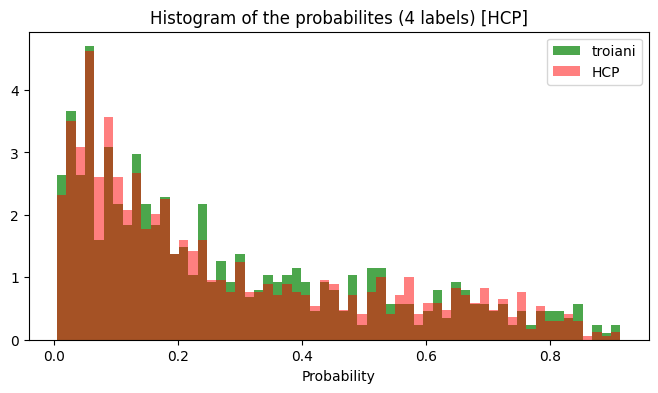

In [276]:
plt.figure(figsize=(8,4))
plt.hist(model.predict_proba(X_train)[:,1], bins=60, color='g', alpha=0.7, label='troiani', density=True)
plt.hist(model.predict_proba(scl_bdd_hcp)[:,1], bins=60, color='red', alpha=0.5, label='HCP', density=True)
plt.xlabel('Probability')
plt.title('Histogram of the probabilites (4 labels) [HCP]')
plt.legend()
plt.show()

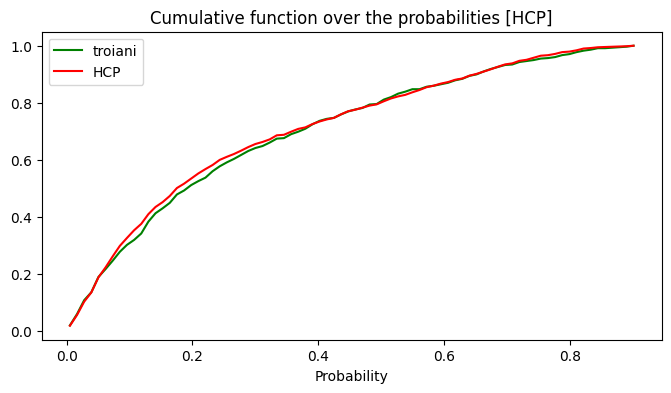

In [277]:
plt.figure(figsize=(8,4))
values_train, base_train = np.histogram(model.predict_proba(X_train)[:,1], bins=80)
cumulative_train = np.cumsum(values_train)
values_HCP, base_HCP = np.histogram(model.predict_proba(scl_bdd_hcp)[:,1], bins=80)
cumulative_HCP = np.cumsum(values_HCP)

plt.plot(base_train[:-1], cumulative_train/len(X), c='g', label='troiani')
plt.plot(base_HCP[:-1], cumulative_HCP/len(scl_bdd_hcp), c='red', label='HCP')
plt.xlabel('Probability')
plt.legend()
plt.title('Cumulative function over the probabilities [HCP]')
plt.show()

### Visualization (UMAP)

In [202]:
import umap

/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Program/2023_jlaval_STSbabies/venvis243185/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [278]:
# to access to the subjects who are labeled
list_lbd_subjects = OFC_labels['Subject'].to_numpy()

In [279]:
scd_bdd_hcp = pd.DataFrame(scl_bdd_hcp, columns=embeddings_HCP.drop('ID', axis=1).columns)
scd_bdd_hcp['Subject'] = embeddings_HCP['ID']
scd_bdd_hcp_labeled = scd_bdd_hcp.set_index('Subject').join(OFC_labels.set_index('Subject'), how='inner')
scd_bdd_hcp_labeled['Dataset'] = 'Troiani'

In [280]:
# to select the subjects that are not labeled
scd_bdd_hcp_not_labeled = scd_bdd_hcp[~scd_bdd_hcp['Subject'].isin(list_lbd_subjects)].set_index('Subject')
scd_bdd_hcp_not_labeled['Dataset'] = 'HCP (not Troiani)'
scd_bdd_hcp_not_labeled['Left_OFC'] = -1
scd_bdd_hcp_not_labeled['Left_Subtype_OFC'] = 'Z'

In [281]:
scl_bdd_ukb = scaler.transform(embeddings_UKB)
scd_bdd_UKB = pd.DataFrame(scl_bdd_ukb, columns=embeddings_HCP.drop('ID', axis=1).columns)
scd_bdd_UKB['Dataset'] = 'UKB'
scd_bdd_UKB['Left_OFC'] = -1
scd_bdd_UKB['Left_Subtype_OFC'] = 'Z'

In [282]:
reducer = umap.UMAP()#random_state=5)

scd_bdd_hcp_labeled['Prediction'] = model.predict(scd_bdd_hcp_labeled.drop(['Dataset','Left_OFC','Left_Subtype_OFC'], axis=1))
scd_bdd_hcp_not_labeled['Prediction'] = model.predict(scd_bdd_hcp_not_labeled.drop(['Dataset','Left_OFC','Left_Subtype_OFC'], axis=1))
scd_bdd_UKB['Prediction'] = model.predict(scl_bdd_ukb)

/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Program/2023_jlaval_STSbabies/venvis243185/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Program/2023_jlaval_STSbabies/venvis243185/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


We fit the reducer only on the UKB database, we concatenate then the two bases and we reduce them together.

In [411]:
reducer.fit(scd_bdd_UKB.drop(['Dataset','Left_OFC','Left_Subtype_OFC','Prediction'], axis=1))

HCP = pd.concat([scd_bdd_hcp_labeled, scd_bdd_hcp_not_labeled], axis=0)
HCP_UKB = pd.concat([HCP, scd_bdd_UKB], axis=0)
embedding2D_troiani = reducer.transform(scd_bdd_hcp_labeled.drop(['Dataset','Left_OFC','Left_Subtype_OFC','Prediction'], axis=1))
embedding2D_HCP = reducer.transform(HCP.drop(['Dataset','Left_OFC','Left_Subtype_OFC','Prediction'], axis=1))
embedding2D_HCP_UKB = reducer.transform(HCP_UKB.drop(['Dataset','Left_OFC','Left_Subtype_OFC','Prediction'], axis=1))

In [284]:
HCP_UKB['Dataset'].unique()

array(['Troiani', 'HCP (not Troiani)', 'UKB'], dtype=object)

In [367]:
def plot_UMAP(ebb2D_dataset, initial_dataset, title, hue):

    unique_values = np.sort(initial_dataset[hue].unique())

    if type(initial_dataset[hue].iloc[0])==type("str"):
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[0] if x == 'Troiani'\
                          else sns.color_palette()[1] if x == 'HCP (not Troiani)' \
                          else sns.color_palette()[2] for x in initial_dataset['Dataset']]
        s = [12 if x == 'Troiani'\
            else 12 if x == 'HCP (not Troiani)' \
            else 0.3 for x in initial_dataset['Dataset']]
    elif -1 in unique_values :
        unique_values[:-1], unique_values[-1] = unique_values[1:], unique_values[0] 
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x] if x!=-1 else sns.color_palette()[4] for x in initial_dataset[hue]]
        s = 10
    else :
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x] for x in initial_dataset[hue]]
        s = 20

    plt.figure(figsize=(12,8))
    plt.scatter(
        ebb2D_dataset[:, 0],
        ebb2D_dataset[:, 1],
        s=s,
        c=dataset_colors)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=12)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=unique_colors[i], markersize=10, 
                                label=f'{unique_values[i]}') 
                    for i in range(len(unique_values))]
    plt.legend(handles=legend_handles, title=hue, loc='best')
    plt.show()

The first figure is made to observe the site effect between ACCP and HCP databases.

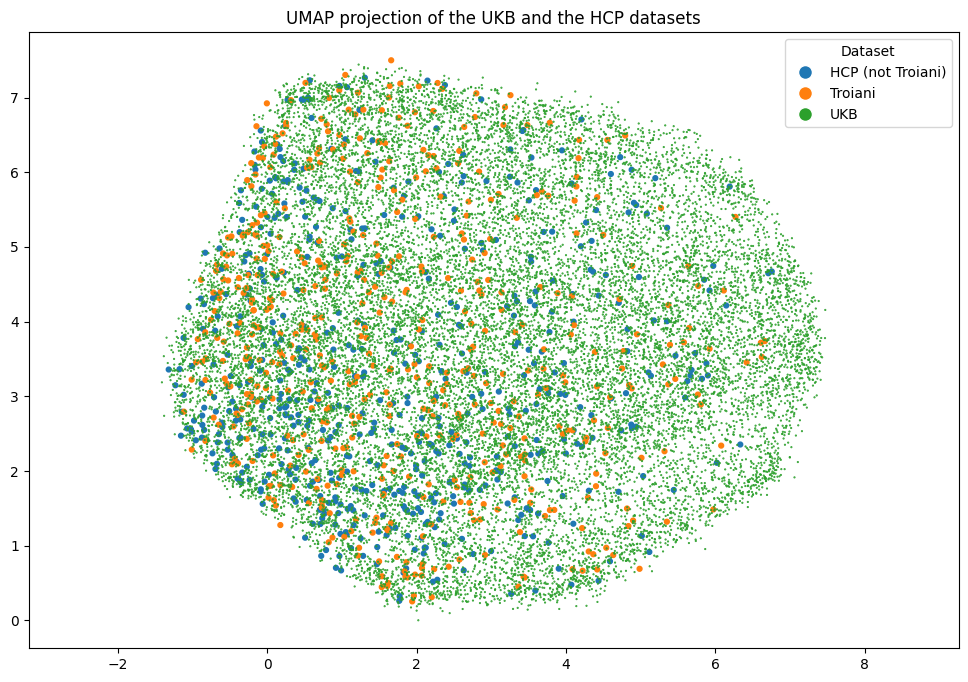

In [349]:
plot_UMAP(embedding2D_HCP_UKB, HCP_UKB, 'UMAP projection of the UKB and the HCP datasets', 'Dataset')

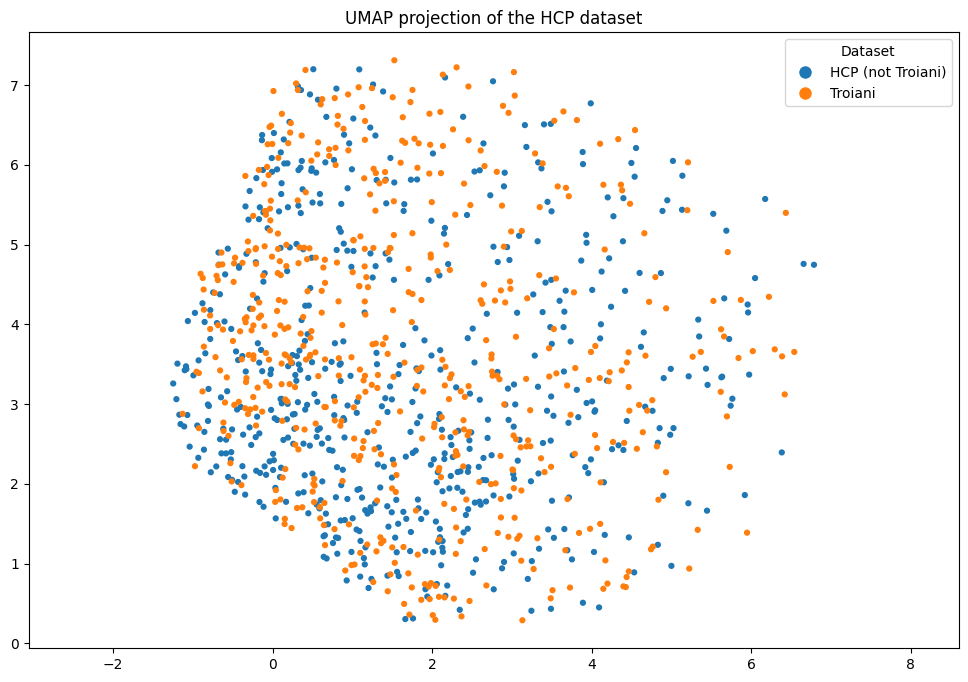

In [350]:
plot_UMAP(embedding2D_HCP, HCP, 'UMAP projection of the HCP dataset', 'Dataset')

The second figure is made to point out the position of the people having the different labels (0,1,2,3) (from the troiani data),  and those we don't know (-1) (from the HCP database part that was not labeled).

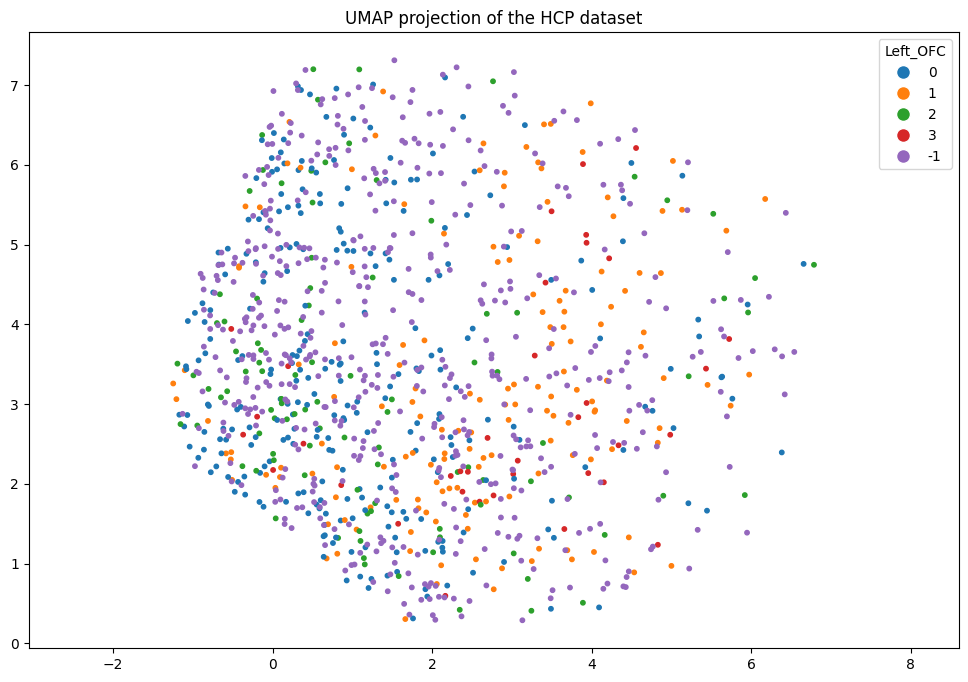

In [368]:
plot_UMAP(embedding2D_HCP, HCP, 'UMAP projection of the HCP dataset', 'Left_OFC')

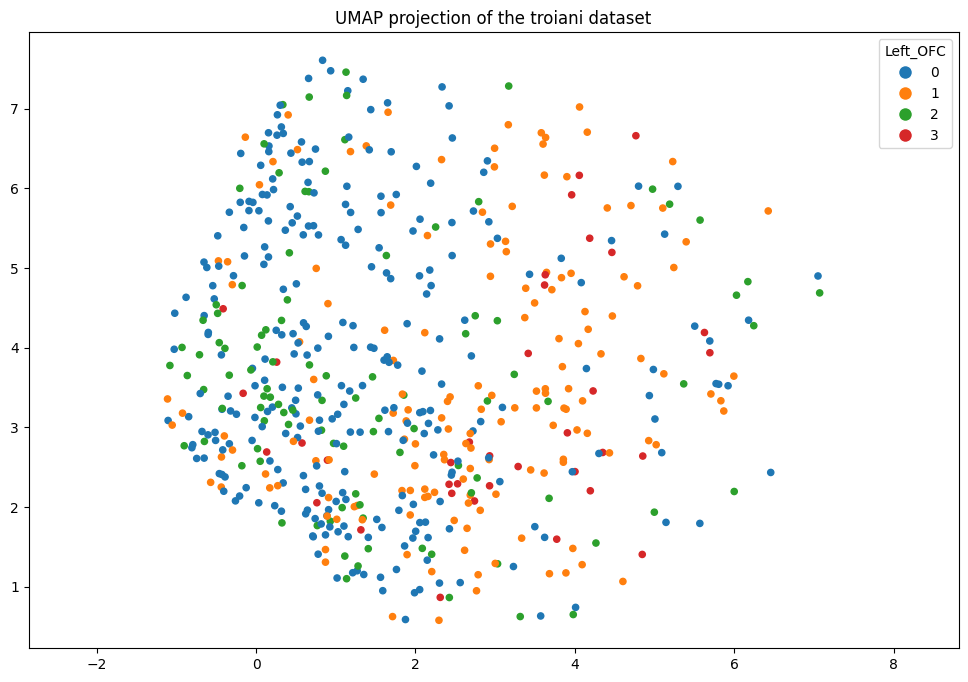

In [412]:
plot_UMAP(embedding2D_troiani, scd_bdd_hcp_labeled, 'UMAP projection of the troiani dataset', 'Left_OFC')

In [383]:
troiani_proba_pred = model.predict_proba(X_train)
troiani_proba_pred[:,0].argsort()[-10:]
troiani_proba_pred[troiani_proba_pred[:,0].argsort()[-10:]][:,0] # top 10 best ranked label 0

array([0.85581951, 0.86160382, 0.86388775, 0.86628345, 0.86711349,
       0.87803003, 0.88769365, 0.89396599, 0.90778334, 0.92719208])

In [420]:
print(model.predict_proba(X_train)[0:10])
print(model.predict_proba(X_train)[0:10].argmax(axis=1))
print(model.predict(X_train)[0:10])

[[0.57989216 0.0759591  0.33557218 0.00857656]
 [0.07797069 0.7874989  0.0319841  0.10254631]
 [0.47924463 0.22314673 0.2853822  0.01222644]
 [0.40190589 0.27905784 0.3047901  0.01424618]
 [0.58701062 0.31521304 0.06402508 0.03375126]
 [0.52660355 0.12552083 0.33362616 0.01424945]
 [0.68912118 0.05486222 0.24149292 0.01452369]
 [0.76370895 0.18216551 0.04747217 0.00665336]
 [0.74496817 0.01756518 0.23141018 0.00605647]
 [0.18483334 0.72392592 0.01947483 0.07176592]]
[0 1 0 0 0 0 0 0 0 1]
[2 1 2 2 0 2 0 0 0 1]


We can do the same one by only keeping the 10 best ranked values given the SVM linear classification, on the troiani database at first, and on the HCP then.

In [252]:
#troiani_proba_pred = model.predict_proba(X_train)
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[0:10]] # top 10 best ranked label 1
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[-10:]] # top 10 best ranked label 0
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]] # check if the prediction are also the ground truth (that's a yes)
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]] # check if the prediction are also the ground truth (that's a yes as well)
#best_ACCP = pd.concat([scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]],scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]]], axis=0)
#embedding2D_best_classified_ACCP = reducer.transform(best_ACCP.drop(['Right_PCS','Dataset','Prediction'], axis=1))
#plot_UMAP(embedding2D_best_classified_ACCP, best_ACCP, 'UMAP projection of the best 10 best-classified subject from ACCP dataset', 'Right_PCS')


Let's see the SVC borders on the UMAP

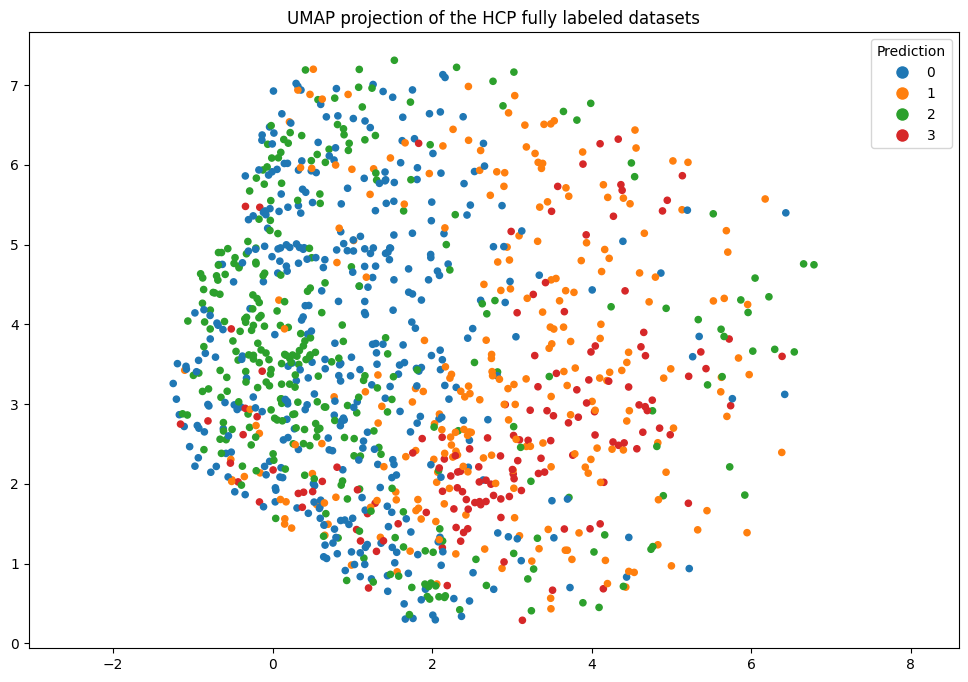

In [369]:
plot_UMAP(embedding2D_HCP, HCP, 'UMAP projection of the HCP fully labeled datasets', 'Prediction')

We can get the ID of the best classified subject and see in the Anatomist if the paracingular is there or not.

In [384]:
HCP_proba_pred = model.predict_proba(scd_bdd_hcp_not_labeled.drop(['Dataset','Left_OFC','Left_Subtype_OFC','Prediction'], axis=1))
HCP_proba_pred[HCP_proba_pred[:,0].argsort()[0:5]][:,0]

/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Program/2023_jlaval_STSbabies/venvis243185/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


array([0.02319242, 0.02625513, 0.02900981, 0.03769476, 0.03875898])

In [385]:
# to get the proba of the first highly classified as label 0

HCP_proba_pred[HCP_proba_pred[:,0].argsort()[-5:]][:,0]

array([0.88987841, 0.90334813, 0.91238237, 0.91671831, 0.91810808])

In [399]:
# to get the index of the mid classified as label 0
scd_bdd_hcp_not_labeled.iloc[HCP_proba_pred[:,0].argsort()[537//2-2:537//2+2]].index

Index([107321, 180937, 979984, 748662], dtype='int64', name='Subject')

First 5 people predicted with label 0.

In [400]:
scd_bdd_hcp_not_labeled.iloc[HCP_proba_pred[:,0].argsort()[0:5]].index

Index([173536, 908860, 432332, 101107, 589567], dtype='int64', name='Subject')

First 5 people predicted with label 1

In [401]:
scd_bdd_hcp_not_labeled.iloc[HCP_proba_pred[:,1].argsort()[0:5]].index

Index([379657, 993675, 150524, 185038, 519950], dtype='int64', name='Subject')

First 5 people predicted with label 2

In [402]:
scd_bdd_hcp_not_labeled.iloc[HCP_proba_pred[:,2].argsort()[0:5]].index

Index([214423, 849971, 208630, 683256, 589567], dtype='int64', name='Subject')

First 5 people predicted with label 3

In [403]:
scd_bdd_hcp_not_labeled.iloc[HCP_proba_pred[:,3].argsort()[0:5]].index

Index([499566, 480141, 112314, 199453, 151223], dtype='int64', name='Subject')

### CSV file generation for SOLAR

In [407]:
df_HCP_prob_pred_OFC_0 = pd.DataFrame({"IID" : list(embeddings_HCP['ID']),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,0]})

df_HCP_prob_pred_OFC_0.to_csv('/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Heritability/data/HCP_prob_pred_OFC_0.csv', index=False)
df_HCP_prob_pred_OFC_0

,IID,Pred
0,100206,0.324892
1,100307,0.579892
2,100408,0.077971
3,100610,0.479245
4,101006,0.401906
...,...,...
1109,992774,0.854737
1110,993675,0.735256
1111,994273,0.797043
1112,995174,0.658737


In [408]:
df_HCP_prob_pred_OFC_1 = pd.DataFrame({"IID" : list(embeddings_HCP['ID']),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,1]})

df_HCP_prob_pred_OFC_1.to_csv('/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Heritability/data/HCP_prob_pred_OFC_1.csv', index=False)
df_HCP_prob_pred_OFC_1

,IID,Pred
0,100206,0.585798
1,100307,0.075959
2,100408,0.787499
3,100610,0.223147
4,101006,0.279058
...,...,...
1109,992774,0.088530
1110,993675,0.010687
1111,994273,0.063154
1112,995174,0.150976


In [409]:
df_HCP_prob_pred_OFC_2 = pd.DataFrame({"IID" : list(embeddings_HCP['ID']),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,2]})

df_HCP_prob_pred_OFC_2.to_csv('/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Heritability/data/HCP_prob_pred_OFC_2.csv', index=False)
df_HCP_prob_pred_OFC_2

,IID,Pred
0,100206,0.047896
1,100307,0.335572
2,100408,0.031984
3,100610,0.285382
4,101006,0.304790
...,...,...
1109,992774,0.053820
1110,993675,0.250234
1111,994273,0.135109
1112,995174,0.172785


In [410]:
df_HCP_prob_pred_OFC_3 = pd.DataFrame({"IID" : list(embeddings_HCP['ID']),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,3]})

df_HCP_prob_pred_OFC_3.to_csv('/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Heritability/data/HCP_prob_pred_OFC_3.csv', index=False)
df_HCP_prob_pred_OFC_3

,IID,Pred
0,100206,0.041414
1,100307,0.008577
2,100408,0.102546
3,100610,0.012226
4,101006,0.014246
...,...,...
1109,992774,0.002912
1110,993675,0.003824
1111,994273,0.004694
1112,995174,0.017502
